# EDA Analysis
**The final purpose of this analysis is to define, for the recommendation model requested and the different functions, for each dataset and function the corresponding columns and data that will be requiered** 

### During the ETL process we already took care of:

[ETL_user_reviews](ETL_user_reviews.ipynb)<br>

-   missing values and data cleaning
-   removed columns of irrelevant information 
-   removed rows with non existant information or not valid.
-   removed duplicated values
-   corrected all datatypes for each and every data and column

### Sentiment Analysis
The dataset we will be using has already underwent the sentiment analysis transformation, so intead of working the EDA with reviews we will have a column named 'sentiment' that shows the result of the Sentiment Analyis process.<br>

### So in the **EDA Analysis** we will mostly focus on:
-   search for outlier values
-   data statistics and description
-   data transformation
-   Variables:
    - user_id: this column contains the unique value identifier for each of the users in Steam.
    - user_url: this column contains the url to the profile for each of the users in Steam.
    - item_id: this column contains the unique value identifier for the game.   
    - helpful: 
    - recommend: 
    - date:
    - year: is the year the game was released
    - sentiment: this column contains the sentiment analysis classification value<br>
        0 --> Negative
        1 --> Neutral
        2 --> Positive

## A summary of what you will find in this notebook:
#### user_id
-   Total number of users on the platform.
-   Calculation of the average number of reviews per user.
-   Exploration of the distribution of the number of reviews per user.
-   Determination of the user with the highest number of reviews.
-   Identification of the user with the highest average number of reviews per year.

**Conclusions:**

*   Only 30% of the users in the Steam platform post reviews, this is 25.446 users
*   this 30% of the users post in average 2.3 reviews 
*   from this 30%, 53% of users post just one review
*   And Less than 2% from the users that post, post more than 8 reviews

#### item_id
-	How many games have reviews
-	What percentage of games have reviews from the total amount of games available in the platform
-   	Exploration of the distribution of the number of reviews per game
-	Average reviews per game
-	Identification of the top 10 games with the highest number of reviews
-	Games with more than 500 reviews

**Conclusions:**

*	16% of all registered games in the platform get reviews, 3.682 out of a total of 22.530.
*	15% of the games get between 1 and 12 reviews
*	The average review per game is 15 reviews	
*	67% of all the reviews are concentrated in just 12 games.

### Helpful
In this column other users qualify if the review was render usefull<br>
This is how many users have qualify the posted review useful.<br>
We are going to transform this column in order to get some insight on how other users render their rating of the user's review

**Conclusions:**
* Most reviews are not rated by other users, **61% of them are not rated**
* 17% of the rated reviews are render helpful by other users

## Recommend and Sentiment Analysis
**We conducted a bivariate analyisis**<br>

In the case of this two variables we are going to run the EDA as a bivariable analysis.<br>
This column is a boolean value that indicates whether the user recommends the games or not. This is if the recomendation is positive there is a 1 and if not a zero.<br>
We can use this column to evaluate or validate our sentiment analysis result. <br>
- How many users post a positive recommendation<br>
- How many users post a positive recommendation and a positive sentiment review<br>
- How many positive recommendations match to a positive sentiment<br>
- How many negative sentiment match to a negative recommendation<br>

#### Sentiment Analysis and Recommend
We are going to consider that all neutral sentiments are positive, and we are going to conduct a type of accuracy score to the sentiment analysis using NLKT and TextBlob libraries given the recommend column.<br>
This is to analyze in some way how accurate our sentiment analysis is.<br>

**Conclusions**
From the accuracy evaluation between both sentiment Analysis we conclude that the NLTK analysis is the best performing.<br>
Now we can review for the results against the recommend from the user:<br>

* **Negatives** We can see that for the recommend True, this is that the user recommends the game even if the review is negative, the percentage of recommend is about 70%, this is that most users although they consider the game not good, they still recommended the game.<br>
* **Neutral** In this case, the review being neutral is not a negative review, so it is not a surprise that users still recommend the game even if the review is not bad. And also, our sentiment analysis performs very good recognizing positive reviews but not so good in classifying neutral reviews.<br>
* **Positive** In this case, we confirm what our accuracy test showed, our sentiment analysis is good at classifying positive reviews, and positive reviews match on 91% of the cases.
Given that our analysis was a fast and simple approach with many opportunities, the results are good, all things considered<br>


In [1]:
import json
import os
import pandas as pd
import gzip
import ast
import numpy as np
import re
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns  

## We start by reading our datasets into pandas df again

In [2]:
# Define the file path for the Parquet file
reviews = 'data/reviews.parquet'

# Read the Parquet file into a pandas DataFrame
df_reviews = pd.read_parquet(reviews)

# 2.2 Reviews

In [3]:
df_reviews.head(3)

,user_id,user_url,item_id,helpful,recommend,date,year,sentiment,sentiment_textblob
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,1250,No ratings yet,True,2011-11-05,2011,2,2
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,22200,No ratings yet,True,2011-07-15,2011,2,2
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,43110,No ratings yet,True,2011-04-21,2011,2,2


In [204]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58400 entries, 0 to 58399
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   user_id             58400 non-null  object        
 1   user_url            58400 non-null  object        
 2   item_id             58400 non-null  int64         
 3   helpful             58400 non-null  object        
 4   recommend           58400 non-null  bool          
 5   date                58400 non-null  datetime64[ns]
 6   year                58400 non-null  int32         
 7   sentiment           58400 non-null  int64         
 8   sentiment_textblob  58400 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int32(1), int64(3), object(3)
memory usage: 3.4+ MB


## user_id
We aimed to gain a deeper understanding of the information within the dataframe, focusing on the following aspects:

-   Total number of users on the platform.
-   Exploration of the distribution of the number of reviews per user.
-   Calculation of the average number of reviews per user.
-   Determination of the user with the highest number of reviews.
-   Identification of the user with the highest average number of reviews per year.

#### Total number of users on the platform and Total amount of users that posted reviews

In [4]:
quantity_user_reviews = df_reviews['user_id'].nunique()
percentage_reviews = (quantity_user_reviews/87626)*100
print('The amount of users that posted reviews in the platform are: ', quantity_user_reviews)
print('The percentage of users that post reviews in the platform are: ', round(percentage_reviews,0))

The amount of users that posted reviews in the platform are:  25446
The percentage of users that post reviews in the platform are:  29.0


#### Exploration of the distribution of the number of reviews per user.

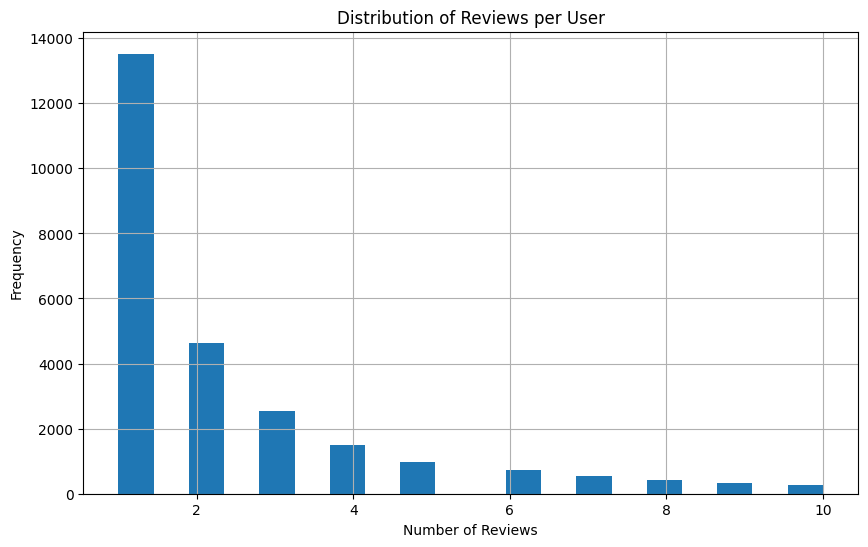

In [5]:
# Group the DataFrame by 'user_id' and count the number of reviews per user
reviews_per_user = df_reviews.groupby('user_id')['item_id'].agg(['count'])

# Compute summary statistics
mean_reviews_per_user = round(reviews_per_user['count'].mean(),2)
review_frequency = reviews_per_user['count'].value_counts()

# Display the distribution of reviews per user
reviews_per_user.hist(bins=20, figsize=(10, 6))
plt.title('Distribution of Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()


In [207]:
# Group by 'user_id' and count the number of reviews for each user
reviews_per_user = df_reviews.groupby('user_id').size().reset_index(name='amount_of_reviews')

# Count the number of users for each amount of reviews
users_per_reviews = reviews_per_user['amount_of_reviews'].value_counts().reset_index()
users_per_reviews.columns = ['amount_of_reviews', 'quantity_of_users']

# Calculate the percentage of users for each amount of reviews
total_users = users_per_reviews['quantity_of_users'].sum()
users_per_reviews['percentage'] = (round(users_per_reviews['quantity_of_users'] / total_users,4)) * 100

# Sort the DataFrame by the amount of reviews
users_per_reviews = users_per_reviews.sort_values(by='amount_of_reviews')

# Display the DataFrame
users_per_reviews

,amount_of_reviews,quantity_of_users,percentage
0,1,13523,53.14
1,2,4625,18.18
2,3,2530,9.94
3,4,1500,5.89
4,5,976,3.84
5,6,739,2.90
6,7,549,2.16
7,8,418,1.64
8,9,324,1.27
9,10,262,1.03


In [208]:
print("Average number of reviews per user:", mean_reviews_per_user)
reviews_per_user.describe()

Average number of reviews per user: 2.3


,amount_of_reviews
count,25446.000000
mean,2.295056
std,2.000813
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,10.000000


### Identification of the 5 top users with the highest number of reviews

In [209]:
# Group the DataFrame by 'user_id' and count the number of reviews per user
reviews_per_user = df_reviews.groupby('user_id')['item_id'].agg(['count'])
reviews_per_user_sorted = reviews_per_user.sort_values(by='count', ascending=False)
reviews_per_user_sorted.head()

,count
user_id,
ArrestMe,10
mixadance,10
keepit1hunid,10
coolvibesandchill,10
ohreoreoreo,10


 #### Determination of the amount of users with 8 or more reviews

In [210]:
reviews_per_user[reviews_per_user['count'] >= 8].count()

count    1004
dtype: int64

#### User_id
*   Only 30% of the users in the Steam platform post reviews, this is 25.446 users
*   this 30% of the users post in average 2.3 reviews 
*   from this 30%, 53% of users post just one review
*   And Less than 2% from the users that post, post more than 8 reviews

### Item_id
This column contains the id number that identifies the game in the platform, it is unique for each game.
Now we will work on getting information about the games and the reviews:
-	How many games have reviews
-	What percentage of games have reviews from the total amount of games available in the platform
-   Exploration of the distribution of the number of reviews per game
-	Average reviews per game
-	Identification of the top 10 games with the highest number of reviews
-	Games with more than 500 reviews

#### How many games have reviews

In [211]:
quantity_games_reviews = df_reviews['item_id'].nunique()
percentage_reviews = (quantity_games_reviews/22530)*100
print('The amount of games that have reviews in the platform are: ', quantity_games_reviews)
print('The percentage of games that get reviews in the platform are: ', round(percentage_reviews,0),' % ')

The amount of games that have reviews in the platform are:  3682
The percentage of games that get reviews in the platform are:  16.0  % 


#### Exploration of the distribution of the number of reviews per game.

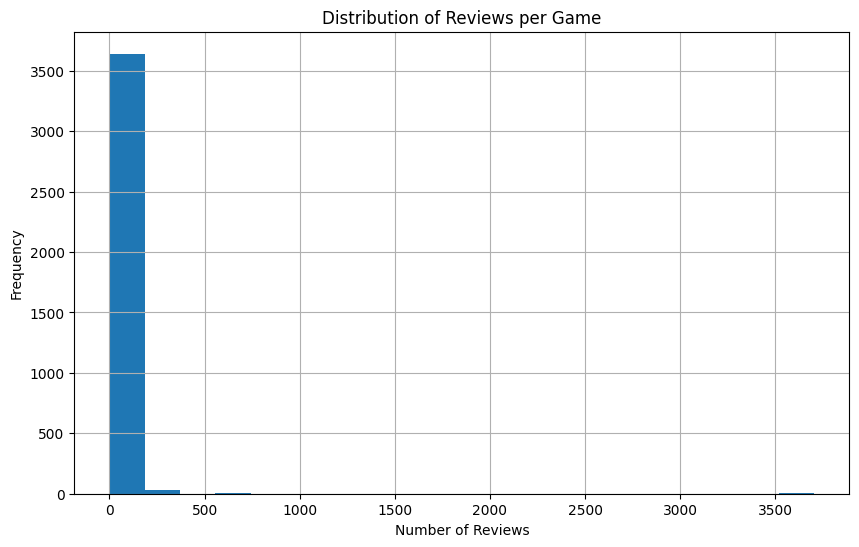

In [212]:
# Group the DataFrame by 'item_id' and count the number of reviews per user
reviews_per_game = df_reviews.groupby('item_id')['user_id'].agg(['count'])

# Compute summary statistics
mean_reviews_per_game = round(reviews_per_game['count'].mean(),2)
review_frequency = reviews_per_game['count'].value_counts()

# Display the distribution of reviews per user
reviews_per_game.hist(bins=20, figsize=(10, 6))
plt.title('Distribution of Reviews per Game')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

In [214]:
# Group by 'item_id' and count the number of reviews for each game
reviews_per_game = df_reviews.groupby('item_id').size().reset_index(name='amount_of_reviews')

# Count the number of games for each amount of reviews
games_per_reviews = reviews_per_game['amount_of_reviews'].value_counts().reset_index()
games_per_reviews.columns = ['amount_of_reviews', 'quantity_of_games']

# Calculate the percentage of users for each amount of reviews
total_games = games_per_reviews['quantity_of_games'].sum()
games_per_reviews['percentage'] = (round(games_per_reviews['quantity_of_games'] / 3682,4)) * 100

# Sort the DataFrame by the amount of reviews
games_per_reviews = games_per_reviews.sort_values(by='amount_of_reviews', ascending= True)
# Display the DataFrame
games_per_reviews.head(12)

,amount_of_reviews,quantity_of_games,percentage
0,1,1504,40.85
1,2,534,14.50
2,3,301,8.17
3,4,185,5.02
4,5,137,3.72
5,6,115,3.12
6,7,78,2.12
7,8,68,1.85
8,9,55,1.49
9,10,39,1.06


##### Average reviews per game

In [215]:
print("Average number of reviews per game:", mean_reviews_per_game)
reviews_per_game.describe()

Average number of reviews per game: 15.86


,item_id,amount_of_reviews
count,3682.000000,3682.000000
mean,256359.072515,15.860945
std,130944.827790,106.237731
min,10.000000,1.000000
25%,210795.000000,1.000000
50%,271922.000000,2.000000
75%,349735.000000,6.000000
max,527340.000000,3704.000000


### Identification of the 10 top games with the highest number of reviews

In [216]:
# Group the DataFrame by 'user_id' and count the number of reviews per user
reviews_per_game = df_reviews.groupby('item_id')['user_id'].agg(['count'])
reviews_per_game_sorted = reviews_per_game.sort_values(by='count', ascending=False)
reviews_per_game_sorted.head(10)

,count
item_id,
730,3704
440,3691
4000,1704
570,1541
218620,1112
304930,1031
252490,806
550,741
105600,729


# games with more than 500 reviews

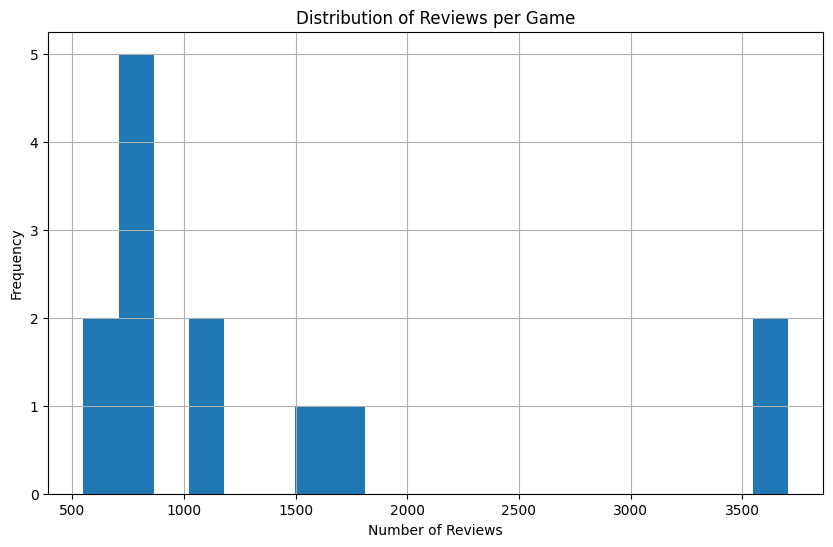

In [217]:
# Group the DataFrame by 'item_id' and count the number of reviews per user
reviews_per_game = df_reviews.groupby('item_id')['user_id'].agg(['count'])
# games with more than 500 reviews
reviews_500 = reviews_per_game[reviews_per_game['count'] >= 500]

# Compute summary statistics
mean_reviews_per_game = round(reviews_500['count'].mean(),2)
review_frequency = reviews_500['count'].value_counts()

# Display the distribution of reviews per user
reviews_500.hist(bins=20, figsize=(10, 6))
plt.title('Distribution of Reviews per Game')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

In [218]:
# Calculate the total number of reviews across all games
total_reviews = reviews_per_game['count'].sum()

# Calculate the percentage for each game
reviews_per_game['percentage'] = round((reviews_per_game['count'] / total_reviews) * 100, 2)

# Sort the DataFrame by the number of reviews
reviews_per_game_sorted = reviews_per_game.sort_values(by='count', ascending=False)

# Display the DataFrame with the percentage column included
reviews_per_game_sorted.head(12)

,count,percentage
item_id,,
730,3704,6.34
440,3691,6.32
4000,1704,2.92
570,1541,2.64
218620,1112,1.90
304930,1031,1.77
252490,806,1.38
550,741,1.27
105600,729,1.25


In [219]:
reviews_500.shape

(13, 1)

##### item_id
*	16% of all registered games in the platform get reviews, 3.682 out of a total of 22.530.
*	15% of the games get between 1 and 12 reviews
*	The average review per game is 15 reviews	
*	**67% of all the reviews are concentrated in just 12 games**

### helpful
In this column other users qualify if the review was render usefull<br>
This is how many users have qualify the posted review useful.<br>
We are going to transform this column in order to get some insight on how other users render their rating of the user's review

In [6]:
df_reviews['helpful'].nunique()

1344

In [7]:
df_reviews['helpful'].value_counts()


helpful
No ratings yet                                       29712
1 of 1 people (100%) found this review helpful        6642
0 of 1 people (0%) found this review helpful          3950
1 of 2 people (50%) found this review helpful         2459
2 of 2 people (100%) found this review helpful        1851
                                                     ...  
64 of 80 people (80%) found this review helpful          1
158 of 165 people (96%) found this review helpful        1
73 of 96 people (76%) found this review helpful          1
12 of 31 people (39%) found this review helpful          1
24 of 34 people (71%) found this review helpful          1
Name: count, Length: 1344, dtype: int64

In [8]:
import re

# Define a function to extract the relevant information
def extract_helpful_info(string):
    # Use regex to extract the relevant parts
    match = re.match(r'(\d+)\s+of\s+(\d+)\s+people\s+\((\d+)%\)', string)
    if match:
        return match.group(1), match.group(2), match.group(3)
    else:
        return None, None, None

# Apply the function to the 'helpful' column and assign the results to new columns
df_reviews = df_reviews.assign(
    helpful_count=lambda x: x['helpful'].apply(lambda y: pd.Series(extract_helpful_info(y))[0]),
    total_count=lambda x: x['helpful'].apply(lambda y: pd.Series(extract_helpful_info(y))[1]),
    rate=lambda x: x['helpful'].apply(lambda y: pd.Series(extract_helpful_info(y))[2])
)

# Convert the new columns to numeric data type
df_reviews[['helpful_count', 'total_count', 'rate']] = df_reviews[['helpful_count', 'total_count', 'rate']].apply(pd.to_numeric)

# Display the DataFrame
df_reviews

,user_id,user_url,item_id,helpful,recommend,date,year,sentiment,sentiment_textblob,helpful_count,total_count,rate
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,1250,No ratings yet,True,2011-11-05,2011,2,2,NaN,NaN,NaN
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,22200,No ratings yet,True,2011-07-15,2011,2,2,NaN,NaN,NaN
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,43110,No ratings yet,True,2011-04-21,2011,2,2,NaN,NaN,NaN
3,js41637,http://steamcommunity.com/id/js41637,251610,15 of 20 people (75%) found this review helpful,True,2014-06-24,2014,2,2,15.0,20.0,75.0
4,js41637,http://steamcommunity.com/id/js41637,227300,0 of 1 people (0%) found this review helpful,True,2013-09-08,2013,2,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
58395,76561198312638244,http://steamcommunity.com/profiles/76561198312...,70,No ratings yet,True,2024-07-10,2024,2,2,NaN,NaN,NaN
58396,76561198312638244,http://steamcommunity.com/profiles/76561198312...,362890,No ratings yet,True,2024-07-08,2024,2,2,NaN,NaN,NaN
58397,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,273110,1 of 2 people (50%) found this review helpful,True,2024-07-03,2024,2,2,1.0,2.0,50.0
58398,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,730,No ratings yet,True,2024-07-20,2024,1,1,NaN,NaN,NaN


In [9]:
# Replace NaN values in the 'rate', 'helpful_count', and 'total_count' columns with 0
df_reviews['rate'] = df_reviews['rate'].fillna(0)
df_reviews['helpful_count'] = df_reviews['helpful_count'].fillna(0)
df_reviews['total_count'] = df_reviews['total_count'].fillna(0)

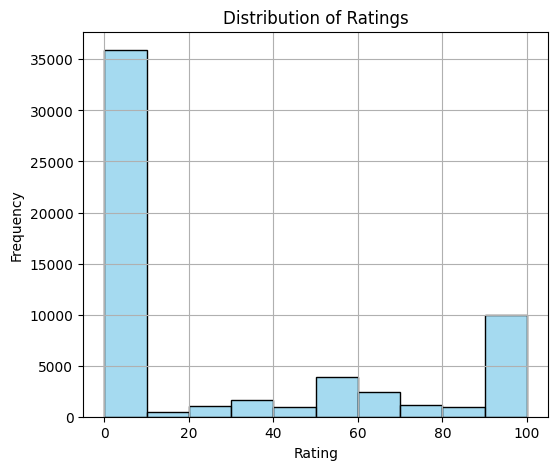

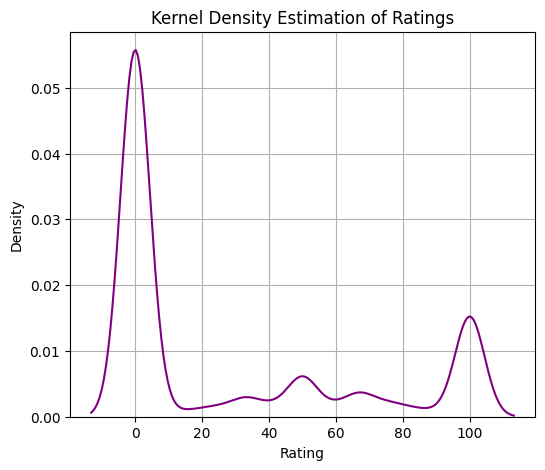

In [10]:
# Plot histogram of the 'rate' column
plt.figure(figsize=(6, 5))
sns.histplot(df_reviews['rate'], bins=10, kde=False, color='skyblue', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot KDE plot of the 'rate' column
plt.figure(figsize=(6, 5))
sns.kdeplot(df_reviews['rate'], color='purple')
plt.title('Kernel Density Estimation of Ratings')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [11]:
# Calculate the value counts of the 'rate' column
rate_counts = df_reviews['rate'].value_counts().sort_index()

# Calculate the total number of reviews
total_reviews = len(df_reviews)

# Calculate the percentage of each rate
rate_percentage = (rate_counts / total_reviews) * 100

# Create a DataFrame to store the results
rate_distribution = pd.DataFrame({'Reviews Count': rate_counts, 'Percentage': rate_percentage})

# Fill in missing values with 0
rate_distribution = rate_distribution.fillna(0)

# Display the DataFrame
rate_distribution

,Reviews Count,Percentage
rate,,
0.0,35734,61.188356
2.0,5,0.008562
3.0,11,0.018836
4.0,13,0.022260
5.0,23,0.039384
...,...,...
95.0,24,0.041096
96.0,14,0.023973
97.0,4,0.006849


#### Helpful
* Most reviews are not rated by other users, **61% of them are not rated**
* 17% of the rated reviews are render helpful by other users

### Recommend and Sentiment Analysis
In the case of this two variables we are going to run the EDA as a bivariable analysis.<br>
This column is a boolean value that indicates whether the user recommends the games or not. This is if the recomendation is positive there is a 1 and if not a zero.<br>
We can use this column to evaluate or validate our sentiment analysis result. <br>
- How many users post a positive recommendation<br>
- How many users post a positive recommendation and a positive sentiment review<br>
- How many positive recommendations match to a positive sentiment<br>
- How many negative sentiment match to a negative recommendation<br>

In [225]:
df_reviews['recommend'].value_counts()

recommend
True     51664
False     6736
Name: count, dtype: int64

In [226]:
# Calculate value counts of 'recommend' column
recommend_counts = df_reviews['recommend'].value_counts()

# Convert to DataFrame
recommend_df = pd.DataFrame(recommend_counts)

# Rename the column
recommend_df.columns = ['Count']

# Calculate percentage
recommend_df['Percentage'] = round((recommend_df['Count'] / recommend_df['Count'].sum()) * 100,0)
recommend_df

,Count,Percentage
recommend,,
True,51664,88.0
False,6736,12.0


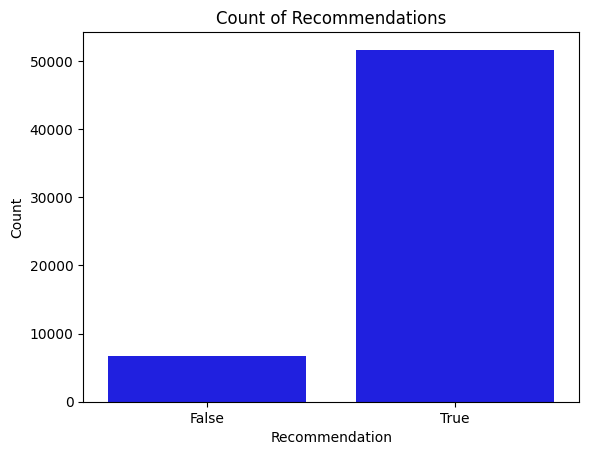

In [227]:
# Plot the count of 'recommend' values
sns.countplot(data=df_reviews, x='recommend', color='blue')

# Add labels and title
plt.xlabel('Recommendation')
plt.ylabel('Count')
plt.title('Count of Recommendations')

# Show the plot
plt.show()

In [230]:
# Calculate value counts of 'recommend' column
sentiment_counts = df_reviews['sentiment'].value_counts()

# Convert to DataFrame
sentiment_df = pd.DataFrame(sentiment_counts)
# Rename the column
sentiment_df.columns = ['Count']

# Calculate percentage
sentiment_df['Percentage'] = round((sentiment_df['Count'] / sentiment_df['Count'].sum()) * 100,0)

sentiment_df

,Count,Percentage
sentiment,,
2,28331,49.0
1,23455,40.0
0,6614,11.0


In [231]:
# Calculate value counts of 'recommend' column
bsentiment_counts = df_reviews['sentiment_textblob'].value_counts()

# Convert to DataFrame
bsentiment_df = pd.DataFrame(bsentiment_counts)

# Rename the column
bsentiment_df.columns = ['Count']

# Calculate percentage
bsentiment_df['Percentage'] = round((bsentiment_df['Count'] / bsentiment_df['Count'].sum()) * 100,0)

bsentiment_df

,Count,Percentage
sentiment_textblob,,
2,31148,53.0
1,13753,24.0
0,13499,23.0


#### Sentiment Analysis 
We are going to consider that all neutral sentiments are positive, and we are going to conduct a type of accuracy score to the sentiment analysis given the recommend column.<br>
This is to analyze in some way how accurate both sentiment analysis are and compare them.

In [232]:
# Add a new column to make the comparison
df_reviews['sentiment_bis'] = df_reviews['sentiment']
df_reviews['sentiment_bis_b'] = df_reviews['sentiment_textblob']
# Replace all occurrences of 1 with 2 in the 'sentiment_bis' column
df_reviews['sentiment_bis'] = df_reviews['sentiment_bis'].replace(1, 2)
df_reviews['sentiment_bis_b'] = df_reviews['sentiment_bis_b'].replace(1, 2)

In [236]:
# Create a new column indicating whether the sentiment matches the recommendation
df_reviews['sentiment_match_recommend'] = (df_reviews['sentiment_bis'] == 2) & df_reviews['recommend']
df_reviews['sentiment_match_recommend_b'] = (df_reviews['sentiment_bis_b'] == 2) & df_reviews['recommend']

# Calculate the accuracy of the sentiment analysis
accuracy = round(df_reviews['sentiment_match_recommend'].mean(),2)*100
accuracy_b = round(df_reviews['sentiment_match_recommend_b'].mean(),2)*100

print("Accuracy of sentiment analysis NLKT:", accuracy,'%')
print("Accuracy of sentiment analysis Textblob:", accuracy_b,'%')

Accuracy of sentiment analysis NLKT: 81.0 %
Accuracy of sentiment analysis Textblob: 71.0 %


So the NLKT Sentiment Analysis is performing better than the textblob, considering the neutral sentiments as positive given that users only tend to not recommend when the review is negative<br>

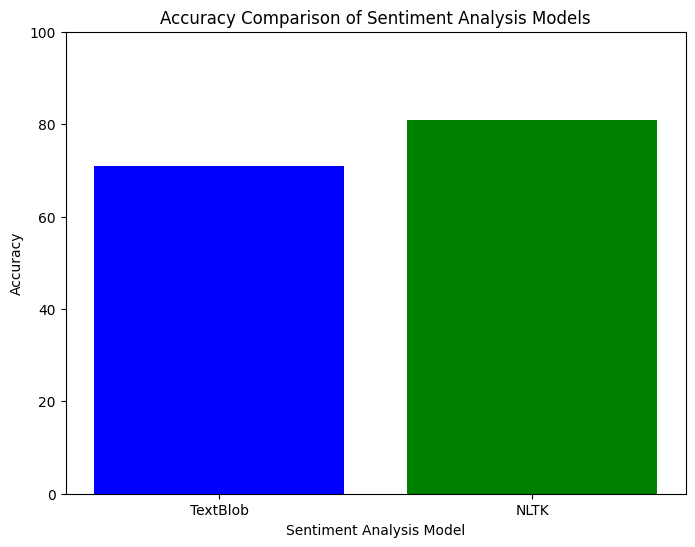

In [244]:
# Plotting
models = ['TextBlob', 'NLTK']
# Calculate the accuracy of the sentiment analysis
accuracy = round(df_reviews['sentiment_match_recommend'].mean(),2)*100
accuracy_b = round(df_reviews['sentiment_match_recommend_b'].mean(),2)*100

accuracies = [accuracy_b, accuracy]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.title('Accuracy Comparison of Sentiment Analysis Models')
plt.xlabel('Sentiment Analysis Model')
plt.ylabel('Accuracy')
plt.ylim(0, 100)  
plt.show()

#### Sentiment Analysis versus Recommend
Now that we calculated that the NLTK system is best performing, we can review for the results:

In [12]:
# Group the DataFrame by 'sentiment' and 'Recommend' columns and calculate count and percentage
recommendations = df_reviews.groupby(['sentiment', 'recommend']).size().unstack(fill_value=0)
recommendations['Total'] = recommendations.sum(axis=1)  # Calculate total reviews per sentiment group
recommendations['Percentage'] = (recommendations[True] / recommendations['Total']) * 100  # Calculate percentage

# Rename the columns for clarity
recommendations.columns = ['Not Recommended', 'Recommended', 'Total', 'Percentage']

# Display the DataFrame
recommendations

,Not Recommended,Recommended,Total,Percentage
sentiment,,,,
0,1972,4642,6614,70.184457
1,2318,21137,23455,90.117246
2,2446,25885,28331,91.366348


* **Negatives** We can see that for the recommend True, this is that the user recommends the game even if the review is negative, the percentage of recommend is about 70%, this is that most users although they consider the game not good, they still recommended the game.<br>
* **Neutral** In this case, the review being neutral is not a negative review, so it is not a surprise that users still recommend the game even if the review is not bad. And also, our sentiment analysis performs very good recognizing positive reviews but not so good in classifying neutral reviews.<br>
* **Positive** In this case, we confirm what our accuracy test showed, our sentiment analysis is good at classifying positive reviews, and positive reviews match on 91% of the cases.
Given that our analysis was a fast and simple approach with many opportunities, the results are good, all things considered<br>

In [15]:
df_reviews

,user_id,user_url,item_id,recommend,date,year,sentiment,rate
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,1250,True,2011-11-05,2011,2,0.0
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,22200,True,2011-07-15,2011,2,0.0
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,43110,True,2011-04-21,2011,2,0.0
3,js41637,http://steamcommunity.com/id/js41637,251610,True,2014-06-24,2014,2,75.0
4,js41637,http://steamcommunity.com/id/js41637,227300,True,2013-09-08,2013,2,0.0
...,...,...,...,...,...,...,...,...
58395,76561198312638244,http://steamcommunity.com/profiles/76561198312...,70,True,2024-07-10,2024,2,0.0
58396,76561198312638244,http://steamcommunity.com/profiles/76561198312...,362890,True,2024-07-08,2024,2,0.0
58397,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,273110,True,2024-07-03,2024,2,50.0
58398,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,730,True,2024-07-20,2024,1,0.0


In [14]:
df_reviews.drop(['helpful_count','helpful','total_count','sentiment_textblob'],axis=1, inplace= True)

In [16]:
# Define the file path for storing the Parquet file
reviews = 'data/reviews_eda.parquet'

# Store the DataFrame as a Parquet file
df_reviews.to_parquet(reviews, index=False)

# Print a message confirming the storage location
print(f'reviews DataFrame was stored into {reviews}')

reviews DataFrame was stored into data/reviews_eda.parquet
